In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import owlready2 as owl
from owlready2 import *
owlready2.reasoning.JAVA_MEMORY = 20000

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

torch.manual_seed(33)

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation




In [2]:
from create_canonical_model import CanonicalModel


All Concept Names and Concept Intersections have been preprocessed for the creation of the canonical model.
Top is not being included in the canonical model.

All restrictions have been preprocessed for the creation of the canonical model.
Starting to reason.



* Owlready2 * Running HermiT...
    java -Xmx200000M -cp /opt/homebrew/Caskroom/miniforge/base/envs/kgenv/lib/python3.11/site-packages/owlready2/hermit:/opt/homebrew/Caskroom/miniforge/base/envs/kgenv/lib/python3.11/site-packages/owlready2/hermit/HermiT.jar org.semanticweb.HermiT.cli.CommandLine -c -O -D -I file:////var/folders/wg/g5861gcs6k5d3rbq_rncztjw0000gn/T/tmpsh5x_71w



Done reasoning. Creating the canonical model.
Father [Class.Father, entity.Q5, owl.Thing, prop.P40.some(owl.Thing)]
Mother [Class.Mother, entity.Q5, owl.Thing, prop.P40.some(owl.Thing)]
Spouse [entity.Q5, owl.Thing, Class.Spouse]
Sibling [Class.Sibling, entity.Q5, owl.Thing]
Child [entity.Q5, owl.Thing, Class.Child]
Q5 [entity.Q5, owl.Thing]
Female [Class.Female, entity.Q5, owl.Thing]
Male [entity.Q5, owl.Thing, Class.Male]

Concluded creating canonical model.


* Owlready2 * HermiT took 0.6556379795074463 seconds
* Owlready * Reparenting entity.Q16019673: {owl.Thing} => {Class.Father}
* Owlready * Reparenting entity.Q2397531: {owl.Thing} => {Class.Father, Class.Child}
* Owlready * Reparenting entity.Q57209: {owl.Thing} => {Class.Sibling}
* Owlready * Reparenting entity.Q829669: {owl.Thing} => {Class.Child}
* Owlready * Reparenting entity.Q11090991: {owl.Thing} => {Class.Sibling}
* Owlready * Reparenting entity.Q10323203: {owl.Thing} => {Class.Sibling}
* Owlready * Reparenting entity.Q2840038: {owl.Thing} => {Class.Child}
* Owlready * Reparenting entity.Q60610: {owl.Thing} => {Class.Child}
* Owlready * Reparenting entity.Q213716: {owl.Thing} => {Class.Sibling}
* Owlready * Reparenting entity.Q312110: {owl.Thing} => {Class.Father, Class.Child, Class.Sibling, Class.Spouse}
* Owlready * Reparenting entity.Q22876077: {owl.Thing} => {Class.Child}
* Owlready * Reparenting entity.Q2446902: {owl.Thing} => {Class.Father, Class.Child}
* Owlready * Repar

In [3]:
from create_pytorch_dataset import GeometricInterpretation, CanonicalModel, EntityEmbedding, SCALE_FACTOR
from create_pytorch_dataset import entity_to_idx_vocab, concept_to_idx_vocab, role_to_idx_vocab, idx_to_entity_vocab, idx_to_concept_vocab, idx_to_role_vocab, idx_finder_dict
from create_pytorch_dataset import trainConceptDataset, testConceptDataset, trainRoleDataset, testRoleDataset, train_ConceptDataLoader, test_ConceptDataLoader, train_RoleDataLoader, test_RoleDataLoader, RoleDataLoader, ConceptDataLoader

================EMBEDDING DIMENSION================
Concept Name dimensions: 8
The number of role names is: 5
The size of the domain is: 84
Role names dimensions: 420

Final embedding dimension: 428
The final dimension for role regions is: 856

===============FINISHED EMBEDDINGS===============
There are 84 vector embeddings.

============FINISHED INTERPS CONCEPT=============
There are 8 regions for concept names.

=============FINISHED INTERPS ROLES==============
There are 5 regions for role names.



In [4]:
from FaithEL_model import FaithEL
from utils import save_model, train_model, plot_score_hak, plot_model

In [5]:
from utils import compute_loss_role, compute_loss_concept

for databatch in RoleDataLoader:
    for epoch in range (1, EPOCHS):
        samples, labels = databatch
        model.train()
        optimizer.zero_grad()
        out1, out2, out3, out4 = model(samples)
        loss = compute_loss_role(out1, out2, out3, out4, labels, loss_fn, GAMMA, PHI, neg_sampling=False)
        loss.backward()
        optimizer.step()

for databatch in ConceptDataLoader:
    for epoch in range (1, EPOCHS):
        samples, labels = databatch
        model.train()
        optimizer.zero_grad()
        out1, out2, out3, out4 = model(samples)
        loss = compute_loss_concept(out1, out2, out3, labels, loss_fn, GAMMA, PHI, neg_sampling=False)
        loss.backward()
        optimizer.step()

def take_distance(model, RoleDataLoader):
    centroid_role = model.role_embedding_dict.weight[0]
    
    for batch in RoleDataLoader:
        batch = batch[0]
        for sample in batch:
            print(f'Role assertion in ontology: r({sample[0]+1}.{sample[2]+1})')

    print('')
    for m, individual1 in enumerate(model.individual_embedding_dict.weight):
        for n, individual2 in enumerate(model.individual_embedding_dict.weight):
            concat = torch.cat((individual1, individual2), axis=0)
            print(f'Distance of concat(Q{m+1}, Q{n+1}) to role centroid: {torch.dist(concat, centroid_role)}')
        print('')

In [6]:
# take_distance(model, RoleDataLoader)

In [7]:
CENTROID_SCORE = True # When set to True, model scores assertion w.r.t distance to the centroid and to the moving parameter for concepts/roles
LR = 0.001
PHI = 1 # Weighs the loss obtained by computing the distance between the role/concept params to the centroid
GAMMA = 1 # Weighs the loss obtained by computing the distance between the role/concept param to the individual/ind_concat parameters
RADIUS = SCALE_FACTOR/2 + 0.1
EMB_DIM = 428

LOG_EPOCH = 10000
EVAL_TRAIN = True
EPOCHS = 200
EVAL_FREQ = 1

NEG_SAMPLING = True
PLOT_LOSS = True

DIM1 = 0
DIM2 = 1

loss_fn = nn.MSELoss()

In [8]:
torch.manual_seed(269)

model = FaithEL(EMB_DIM, PHI, RADIUS, GAMMA,
                entity_to_idx_vocab, concept_to_idx_vocab, role_to_idx_vocab,
                )

optimizer = optim.Adam(model.parameters(), lr=LR)

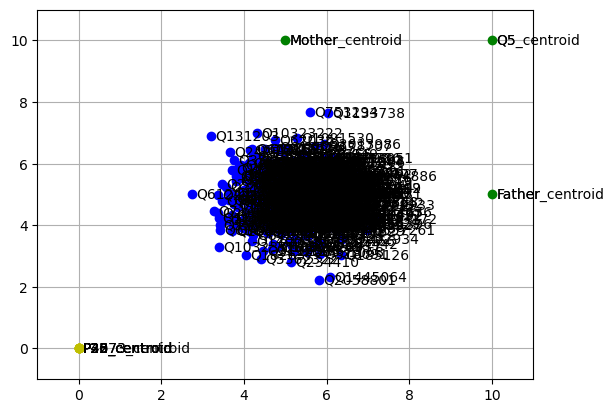

In [9]:
plot_model(model, GeometricInterpretation, idx_to_entity_vocab, idx_to_concept_vocab, idx_to_role_vocab, SCALE_FACTOR, DIM1, DIM2)

In [10]:
model_list = []

In [11]:
original_role_embeddings = model.role_embedding_dict.weight[4]

In [12]:
original_ind_embeddings = model.individual_embedding_dict

Epoch 1: Initiating evaluation. 

Epoch 2: Initiating evaluation. 

Epoch 3: Initiating evaluation. 

Epoch 4: Initiating evaluation. 

Epoch 5: Initiating evaluation. 

Epoch 6: Initiating evaluation. 

Epoch 7: Initiating evaluation. 

Epoch 8: Initiating evaluation. 

Epoch 9: Initiating evaluation. 

Epoch 10: Initiating evaluation. 

Epoch 11: Initiating evaluation. 

Epoch 12: Initiating evaluation. 

Epoch 13: Initiating evaluation. 

Epoch 14: Initiating evaluation. 

Epoch 15: Initiating evaluation. 

Epoch 16: Initiating evaluation. 

Epoch 17: Initiating evaluation. 

Epoch 18: Initiating evaluation. 

Epoch 19: Initiating evaluation. 

Epoch 20: Initiating evaluation. 

Epoch 21: Initiating evaluation. 

Epoch 22: Initiating evaluation. 

Epoch 23: Initiating evaluation. 

Epoch 24: Initiating evaluation. 

Epoch 25: Initiating evaluation. 

Epoch 26: Initiating evaluation. 

Epoch 27: Initiating evaluation. 

Epoch 28: Initiating evaluation. 

Epoch 29: Initiating evaluati

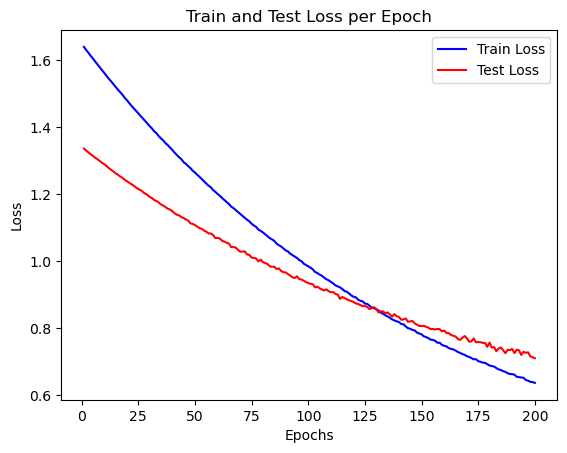

In [13]:
train_loss_list, test_loss_list, train_hits_at_k_concept, test_hits_at_k_concept, train_hits_at_k_role, test_hits_at_k_role, = train_model(model, GeometricInterpretation,
                                                                                                                                           train_ConceptDataLoader, train_RoleDataLoader, test_ConceptDataLoader, test_RoleDataLoader,
                                                                                                                                           trainConceptDataset, testConceptDataset, trainRoleDataset, testRoleDataset,
                                                                                                                                           EPOCHS, LOG_EPOCH, EVAL_FREQ, EVAL_TRAIN, loss_fn, optimizer,
                                                                                                                                           idx_to_entity_vocab, entity_to_idx_vocab,
                                                                                                                                           idx_to_concept_vocab, concept_to_idx_vocab,
                                                                                                                                           idx_to_role_vocab, role_to_idx_vocab,
                                                                                                                                           CENTROID_SCORE, NEG_SAMPLING, PLOT_LOSS
                                                                                                                                           )

model_list.append(save_model(CENTROID_SCORE, LR, PHI, GAMMA, EMB_DIM, EPOCHS, LOG_EPOCH, EVAL_FREQ, EVAL_TRAIN,
                             loss_fn, model, optimizer, train_loss_list, test_loss_list, train_hits_at_k_concept, test_hits_at_k_concept, train_hits_at_k_role, test_hits_at_k_role))

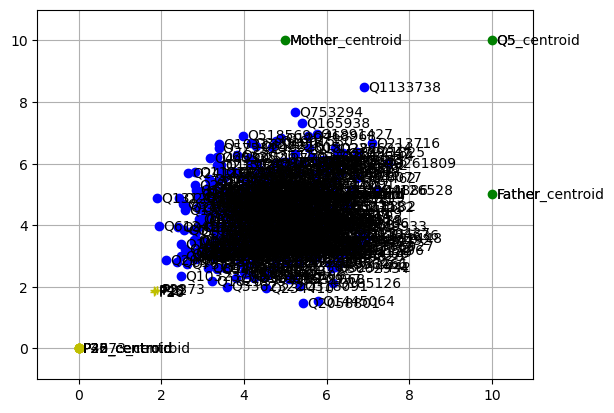

In [14]:
plot_model(model, GeometricInterpretation, idx_to_entity_vocab, idx_to_concept_vocab, idx_to_role_vocab, SCALE_FACTOR, DIM1, DIM2)

In [17]:
pos_list = -1
TOPK = 2

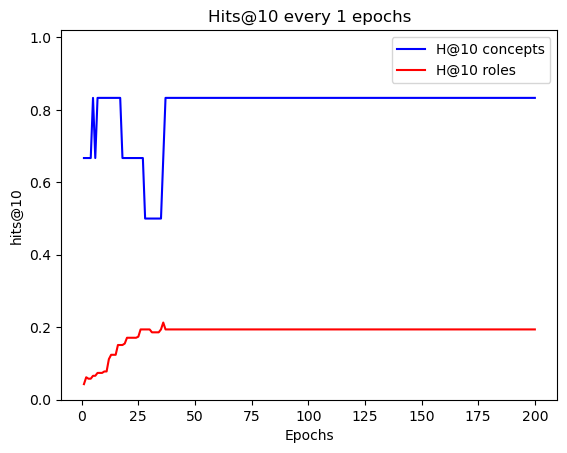

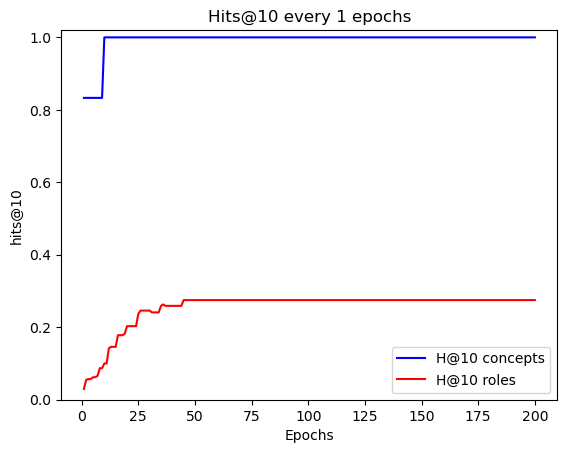

In [18]:
plot_score_hak(model_list[pos_list]['test_hits_at_k_concept'], model_list[pos_list]['test_hits_at_k_role'], TOPK, model_list[pos_list]['epochs'], model_list[pos_list]['eval_freq'])
plot_score_hak(model_list[pos_list]['train_hits_at_k_concept'], model_list[pos_list]['train_hits_at_k_role'], TOPK, model_list[pos_list]['epochs'], model_list[pos_list]['eval_freq'])